# 0. Magic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

Import และประกาศฟังก์ชันที่จำเป็น

In [2]:
import operator

def test(a, b, cmp, cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a, b, operator.eq, '==')

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)    

In [3]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
mpl.rcParams['image.cmap'] = 'gray'

# 2. ดาวน์โหลด Data

ในเคสนี้เราจะใช้ MNIST Dataset แบบ Pickle คือข้อมูลแบบ NumPy Array

In [4]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [5]:
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/home/jupyter/.fastai/data/mnist.pkl.gz')

In [6]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

# 3. ดู Data

In [7]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

In [8]:
x_train.shape, x_train

(torch.Size([50000, 784]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [9]:
y_train.shape, y_train

(torch.Size([50000]), tensor([5, 0, 4,  ..., 8, 4, 8]))

In [10]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

ตรวจเช็คความเรียบร้อยของข้อมูล

In [11]:
assert n == y_train.shape[0] == 50000
test_eq(c, 28*28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [12]:
img = x_train[0]

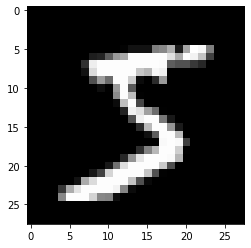

In [13]:
plt.imshow(img.view(28, 28))

In [14]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

# 4. เปรียบเทียบอัลกอริทึม การคูณเมตริกซ์

เราจะใช้ข้อมูลจาก MNIST มาใส่ Matrix m1 ไว้ 10 Row

In [15]:
m1 = x_valid[:10]
m2 = weights

In [16]:
m1.shape, m2.shape

(torch.Size([10, 784]), torch.Size([784, 10]))

## 4.1 ลูปซ้อนกัน 3 ชั้น

In [17]:
def matmul1(a, b):
    # a row, a column
    ar, ac = a.shape
    # b row, b column
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i, k] * b[k, j]
    return c

In [18]:
%timeit t1 = matmul1(m1, m2)

2.89 s ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


เทสความถูกต้อง ว่าผลลัพธ์ตรงกันไหม

In [19]:
test_near(m1.matmul(m2), matmul1(m1, m2))

## 4.2 ใช้ Element-wise

ใน Loop ในสุด แทนที่เราวนลูป บวกทีละตัว เราจะใช้[คุณสมบัติ Element-wise ของ Tensor](https://www.bualabs.com/archives/1629/what-is-tensor-element-wise-broadcasting-reshape-dimensions-operations-high-order-tensor-numpy-array-matrix-vector/) มาช่วยประมวลผลขนานกันไปทั้งหมดเลย พร้อมกันทีเดียว 

In [20]:
def matmul2(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
                c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [21]:
%timeit t2 = matmul2(m1, m2)

4.9 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


เทสความถูกต้อง ว่าผลลัพธ์ตรงกันไหม

In [22]:
test_near(m1.matmul(m2), matmul2(m1, m2))

## 4.3 ใช้ Broadcasting

ใน Loop ต่อมา แทนที่เราวนลูป ทีละ Column เราจะใช้[คุณสมบัติ Broadcasting ของ Tensor](https://www.bualabs.com/archives/1629/what-is-tensor-element-wise-broadcasting-reshape-dimensions-operations-high-order-tensor-numpy-array-matrix-vector/) มาช่วยประมวลผลขนานกันไปทั้งหมดเลย พร้อมกันทีเดียว 

In [23]:
def matmul3(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
                c[i, :] = (a[i, :] * b[:, :].t()).sum(1)
    return c

In [24]:
%timeit t3 = matmul3(m1, m2)

890 µs ± 217 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


เทสความถูกต้อง ว่าผลลัพธ์ตรงกันไหม

In [25]:
test_near(m1.matmul(m2), matmul3(m1, m2))

## 4.4 ใช้ Einstein Summation

อันนี้ไม่เกี่ยวกับ Tensor แต่เป็น ฟังก์ชันพิเศษ ที่ประมวลผล Tensor ในมิติตาม Parameter ที่เรากำหนด สามารถใช้งานได้หลากหลาย เราจะอธิบายต่อไป

In [26]:
def matmul4(a, b):
    return torch.einsum('ik,kj->ij', a, b)

In [27]:
%timeit t4 = matmul4(m1, m2)

86.1 µs ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


เทสความถูกต้อง ว่าผลลัพธ์ตรงกันไหม

In [28]:
test_near(m1.matmul(m2), matmul4(m1, m2))

## 4.5 ใช้ PyTorch API

ใช้ฟังก์ชัน tensor.matmul

In [29]:
%timeit t5 = m1.matmul(m2)

16.7 µs ± 7.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


ใช้เครื่องหมาย @ ในการ Matrix Multiplication

In [30]:
%timeit t6 = m1 @ m2

9.74 µs ± 118 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# 5. สรุป

ตารางเปรียบเทียบ อัลกอริทึมทั้งหมด เวลาที่ใช้ แล้วเร็วขึ้นกี่เปอร์เซ็น

| ลำดับ 	| อัลกอริทึม    	| เวลา 	|   ไมโครวินาที 	|    เร็วขึ้น 	|
|:----:	|-----------------------------------------	|--------------:	|  ----------:	|------------:	|
| 1 	| Loop 3 ชั้น   	|  3 วินาที 	| 3,000,000 	| 0% 	|
| 2 	| Loop 2 ชั้น + Element-wise  	|    5 มิลลิวินาที 	| 5,000 	| 60,000% 	|
| 3 	| Loop 1 ชั้น + Element-wise + Broadcasting  	|   900 ไมโครวินาที 	| 900 	| 333,333.3% 	|
| 4 	| Einstein Summation 	|  90 ไมโครวินาที 	| 90 	| 3,333,333% 	|
| 5 	| torch.matmul 	|  20 ไมโครวินาที 	| 20 	| 15,000,000% 	|
| 6 	| @ Operator 	|  10 ไมโครวินาที 	| 10 	| 30,000,000% 	|



*กระบวนการทั้งหมดดำเนินการอยู่บน Tensor เหมือนกัน แต่ต่างกันที่อัลกอริทึม ดังนั้นการออกแบบ เขียนโปรแกรมแบบ Vectorization จึงมีความสำคัญ มีผลต่อประสิทธิภาพการทำงานของระบบอย่างมาก* 

# Credit

* https://course.fast.ai/videos/?lesson=8
* https://ipython.readthedocs.io/en/stable/interactive/magics.html
* https://www.deeplearning.ai/
* https://pytorch.org/docs/stable/tensors.html